# Text-based Model: Training Models : Trial Phase

-------   

> In this part, we will try to find out the most suitable classification technique for our problem while considering different possibilities. We will check the following classification algorithms:
>> * **DummyClassifier** : as a reference or a baseline to evaluate the efficiency of the different algorithms 
>> * **LogisticRegression** 
>> * **MultinomialNB** 
>> * **RandomForestClassifier**
>> * **XGBClassifier**  

> We will train these models over different inputs:
>> * **Textual data**: text_based models
>> * **Numerical metadata**: metadata_based models
>> * **Textual and Numerical metadata** : combined models

> Each model is trained considering the different inputs and the results are saved to the path : **models/trial/[text_based or metadata_based or combined]**. Please go to the right folder path to check the results.   
The results are saved in **text** files under the name of the used classifier. You can find as well the trained models as **pickle** files. In each related classifier text file, you find the **Accuracy, F1, Precision and Recall** scores and other details. 

----------- 

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;">
The term <b>best</b> algorithm is used to refer to the algorithm that gives the best results <b>among the evaluated algorithms</b> in this project and not among all the classificatiion algorithms.
</div> </pre> 

In [24]:
#Generic libs
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

# predefined modules
from modules import Train_Functions as Train_F

# ML libs
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

#global params
dataset_path = 'data/autism_with_metadata.csv'

model_path = 'models/'
report_path = 'models/'
tfidf_path = 'data/tfidf_most_common.csv'

val_ratio = 0.2
seed = 0

## Load Data

In [2]:
data = pd.read_csv(dataset_path)
data.head()

,name,age,sex,speech,ASD,abs_age,clean_annotated_speech,lemmatized_speech,meaningful_speech,structured_speech,...,n_uni,n_rep,n_inq,n_ono,n_hes,n_mis,n_disf,age_in_months,n_diff_words,density
0,Eigsti,5;03.10,0,\tokay .,1,5.0,okay,okay,okay,okay,...,0,0,0,0,0,0,0,63.0,1,4
1,Eigsti,5;03.10,0,\tdid you see this ?,1,5.0,did you see this,do you see this,do you see this,do you see this,...,0,0,0,0,0,0,0,63.0,4,13
2,Eigsti,5;03.10,0,\tyeah .,1,5.0,yeah,yeah,yeah,yeah,...,0,0,0,0,0,0,0,63.0,1,4
3,Eigsti,5;03.10,0,\txxx let's see +...,1,5.0,uni let's see inq,uni let us see inq,uni let us see inq,uni let we see inq,...,1,0,1,0,0,0,0,63.0,3,8
4,Eigsti,5;03.10,0,\txxx .,1,5.0,uni,uni,uni,uni,...,1,0,0,0,0,0,0,63.0,0,0


In [3]:
Train_F.missing(data)

,Variable,n_missing,p_missing
0,name,0,0.00
24,age_in_months,0,0.00
23,n_disf,0,0.00
22,n_mis,0,0.00
21,n_hes,0,0.00
20,n_ono,0,0.00
19,n_inq,0,0.00
18,n_rep,0,0.00
17,n_uni,0,0.00
16,n_gue,0,0.00


## Features and Target

In [4]:
# 1. drop null values
data.dropna(subset=['clean_annotated_speech'], inplace=True)

# define the features and the target
numerical_features = ['sex','age_in_months','len_clean_annotated_speech',
       'len_meaningful_speech', 'len_structured_speech', 'n_bab', 'n_gue',
       'n_uni', 'n_rep', 'n_inq', 'n_ono', 'n_hes', 'n_mis', 'n_disf',
        'n_diff_words', 'density']

nlp_features = ['clean_annotated_speech']

y = data['ASD'].values

## Classifiers to check

In [5]:
classifiers = [
    DummyClassifier(random_state=seed), 
    LogisticRegression(random_state=seed), 
    MultinomialNB(), 
    RandomForestClassifier(verbose=2,n_jobs=-1,random_state=seed),
    XGBClassifier()
]

## TF-IDF Vectorizer (Most Common features)

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;">
We want to check what are the most common features given by the <b>TfidfVectorizer</b> 
</div> </pre> 

In [31]:
tfidf_vect = TfidfVectorizer(max_features= 5000, use_idf=True)

trsfm = tfidf_vect.fit(data['clean_annotated_speech'])
X_tfidf = tfidf_vect.transform(data['clean_annotated_speech'])
print(f"n_features : {X_tfidf.shape[1]}")

X_tfidf = pd.DataFrame(X_tfidf.todense(), columns = tfidf_vect.get_feature_names(), index = data.index)

print(f'Number of docs: {X_tfidf.shape[0]} \nVocabulary size: {X_tfidf.shape[1]}') #(nb_docs/speech; size of vocabulary)

#common terms
common_tfidf = pd.DataFrame(X_tfidf.mean(axis=0), columns = ['tfidf'], index = tfidf_vect.get_feature_names())
common_tfidf.sort_values(by = 'tfidf', ascending=False, inplace = True)
# save to a csv file
common_tfidf.to_csv(tfidf_path, index=True, quoting=csv.QUOTE_NONNUMERIC)

n_features : 5000
Number of docs: 396050 
Vocabulary size: 5000


In [23]:
var = common_tfidf['tfidf'].var()
mean = common_tfidf['tfidf'].mean()
minim = common_tfidf['tfidf'].min()
maxim = common_tfidf['tfidf'].max()
print(f'Variance_tfidf: {var}')
print(f'Min_tfidf: {minim}')
print(f'Max_tfidf: {maxim}')

Variance_tfidf: 3.685570611743429e-06
Min_tfidf: 2.524933720489837e-06
Max_tfidf: 0.06396818642095348


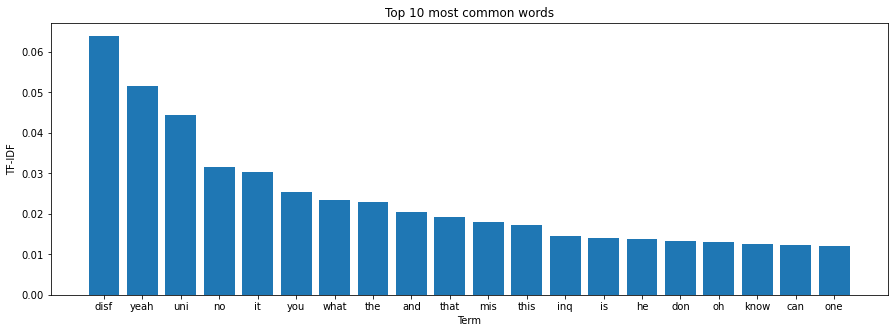

In [33]:
plt.figure(figsize=(15,5))
plt.bar(x = common_tfidf.index[0:20], height=common_tfidf.tfidf[0:20].values)
plt.xlabel("Term")
plt.ylabel("TF-IDF")
plt.title("Top 10 most common words")
plt.show()

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;">
Disfluency, unintelligibility, mispelling, and incompletion are at the top of the most common words. Yes/No answers and pointing words are also in the list.
</div> </pre> 

## Text based Model

In [ ]:
# define the features to be used
cols = nlp_features
X = data['clean_annotated_speech']

# split the data into training and validation subsets
X_train, X_val, y_train, y_val = Train_F.train_val(X, y, val_ratio) 

# Evaluate classifiers
for clf in classifiers:
    pipe = Pipeline([
        ('tfidfV', TfidfVectorizer()), 
        ('classifier', clf),
    ])
    # fit the model and save the results
    clf_name = str(type(pipe.named_steps['classifier'])).split(".")[-1][:-2]
    Train_F.classifier(pipe, clf_name, X_train, y_train, X_val, y_val, stage='trial/text_based', intermediate=False)

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;">
Clearly, the <b>RandomForest Classifier</b> gives the best results on textual data.
</div> </pre> 

## Metadata based Model

In [ ]:
# define the features to be used
cols = numerical_features
X = data[cols]

# split the data into training and validation subsets
X_train, X_val, y_train, y_val = Train_F.train_val(X, y, val_ratio) 

# Evaluate classifiers
for clf in classifiers:
    # fit the model and save the results
    clf_name = str(type(clf)).split(".")[-1][:-2]
    Train_F.classifier(clf, clf_name, X_train, y_train, X_val, y_val, stage='trial/metadata_based', intermediate=False)

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;">
The <b>RandomForest Classifier</b> also gives the best results on numerical metadata. However, this model trained on numerical metadata gives better scores than that trained on textual data.
</div> </pre> 

## Combined Model

In [ ]:
# combine the textual features and the numerical features
cols = numerical_features + nlp_features
X = data[cols]

# split the data into training and validation subsets
X_train, X_val, y_train, y_val = Train_F.train_val(X, y, val_ratio) 

for clf in classifiers:
    preprocessor = ColumnTransformer(
        [('tfidfV', TfidfVectorizer(), 'clean_annotated_speech')], 
        remainder='passthrough'
    )


    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("classifier", clf)]
    )
    # fit the model and save the results
    clf_name = str(type(pipe.named_steps['classifier'])).split(".")[-1][:-2]
    Train_F.classifier(pipe, clf_name, X_train, y_train, X_val, y_val, stage='trial/combined', intermediate=False)

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;">
The <b>RandomForest Classifier</b> always gives the best results and performs better with mixed inputs.  
</div> </pre> 

## Conclusion  
The reason for which this ensemble classifier performs better than the other classifiers is that **the RandomForest classifier is the least sensitive to noise** that is omnipresent in the dataset. The noise comes with the fact that the dataset contains children's speech where there is no standard vocabulary like the used one by adults. 